# Figures for the article


In [1]:
import os

folder_to_save_figure = os.path.join("figures", "Article")

if not os.path.exists(folder_to_save_figure):
    os.makedirs(folder_to_save_figure)

## Data Viz


In [2]:
import sys
import os
import gc

sys.path.append(os.path.join("..", "src"))

import numpy as np
import matplotlib.pyplot as plt

import wandb

os.environ["WANDB_SILENT"] = "false"

import torch
from torch.utils.data.dataset import Subset

# import dataset class from torch
from torch.utils.data import Dataset

from utils.metautils import (
    Adam_meta,
    test,
    train,
    BNNAxel,
    get_weight_histogram,
)
from utils.experimentutils import (
    create_saving_architecture,
    get_random_permuted_subset_loader,
    evaluate_model,
)


config = {
    "NUMBER_OF_TASKS": 2,
    "NUMBER_OF_EPOCH_PER_TASK": 20,
    "META": 5.0,
    "WEIGHT_DECAY": 1e-8,
    "WIDTH_INIT": 0.5,
    "DATA_DIR": "D:/Travail/Australie/Academique/Data/TUH/reshuffle",
    "NET_SHAPE": (2898, 512, 512, 2),
    "LR": 0.0005,
    "BATCH_SIZE": 512,
}

### EEG Data Viz


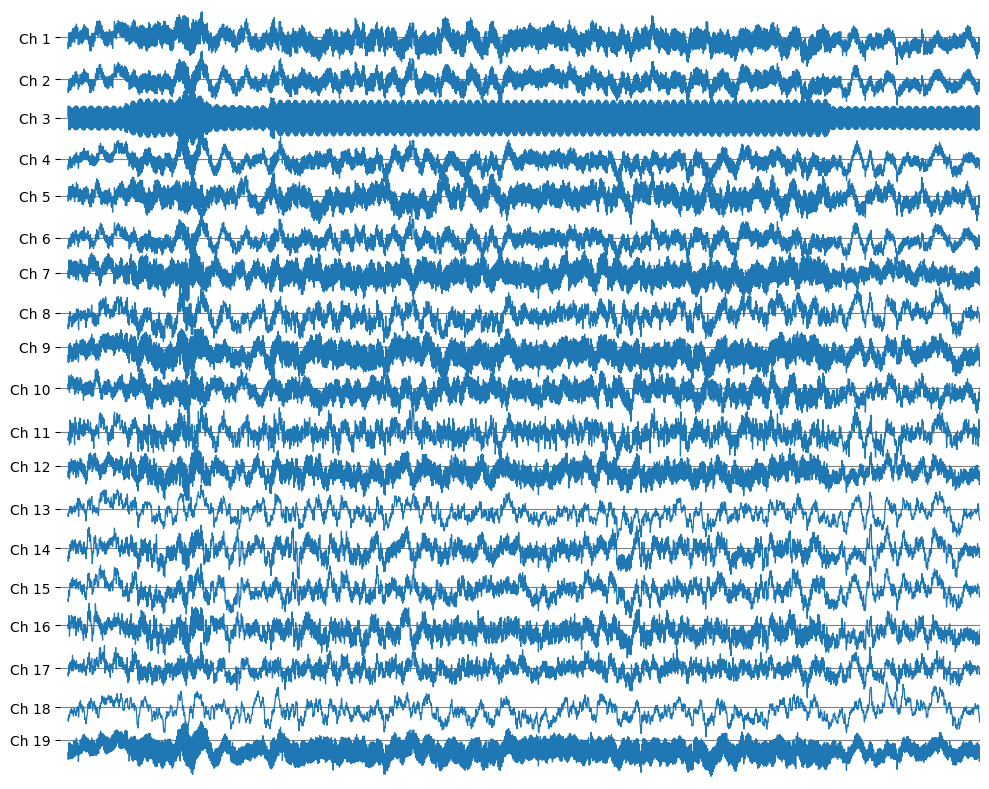

In [3]:
EEG_data = np.load(
    os.path.join(config["DATA_DIR"], "dev_x_not_mmap.npy"), mmap_mode="r"
)


def plot_eeg(data, sample_rate=250, save_path=None, linewidth=0.6):
    """
    Plot EEG data.

    :param data: A 2D numpy array where each row is a channel and columns are data points.
    :param sample_rate: The sample rate of the EEG data.
    :param save_path: Path to save the SVG or PDF. If None, just show the plot.
    :param linewidth: Line width for the EEG plots.
    """
    num_channels, num_samples = data.shape
    time = np.arange(0, num_samples) / sample_rate

    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 8), sharex=True)

    for i, ax in enumerate(axes):
        ax.plot(
            time, data[i, :], "-", linewidth=linewidth
        )  # Custom linewidth and comma marker

        # Remove spines for cleaner look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # Set channel number as the only y tick
        ax.set_xlim([-0.1, time[-1]])
        ax.set_yticks([0])
        ax.set_yticks([0])
        ax.set_yticklabels([f"Ch {i+1}"])
        # Move y-tick labels closer to the start of the plot

        ax.grid(True, color="black", alpha=0.5)

        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])

        ax.set_facecolor("none")  # Transparent background for each subplot

    fig.patch.set_facecolor("none")  # Set the entire figure's background to transparent
    plt.tight_layout(h_pad=-1.5)  # Negative padding to make subplots overlap

    if save_path:
        plt.savefig(
            save_path, format=save_path.split(".")[-1], transparent=True
        )  # Save with a transparent background
        plt.show()


plot_eeg(
    EEG_data[0, :, :].T,
    250,
    linewidth=0.9,
    save_path=os.path.join(folder_to_save_figure, "eeg_figure.svg"),
)

### STFT Data Viz


#### STFT before 50hz and average


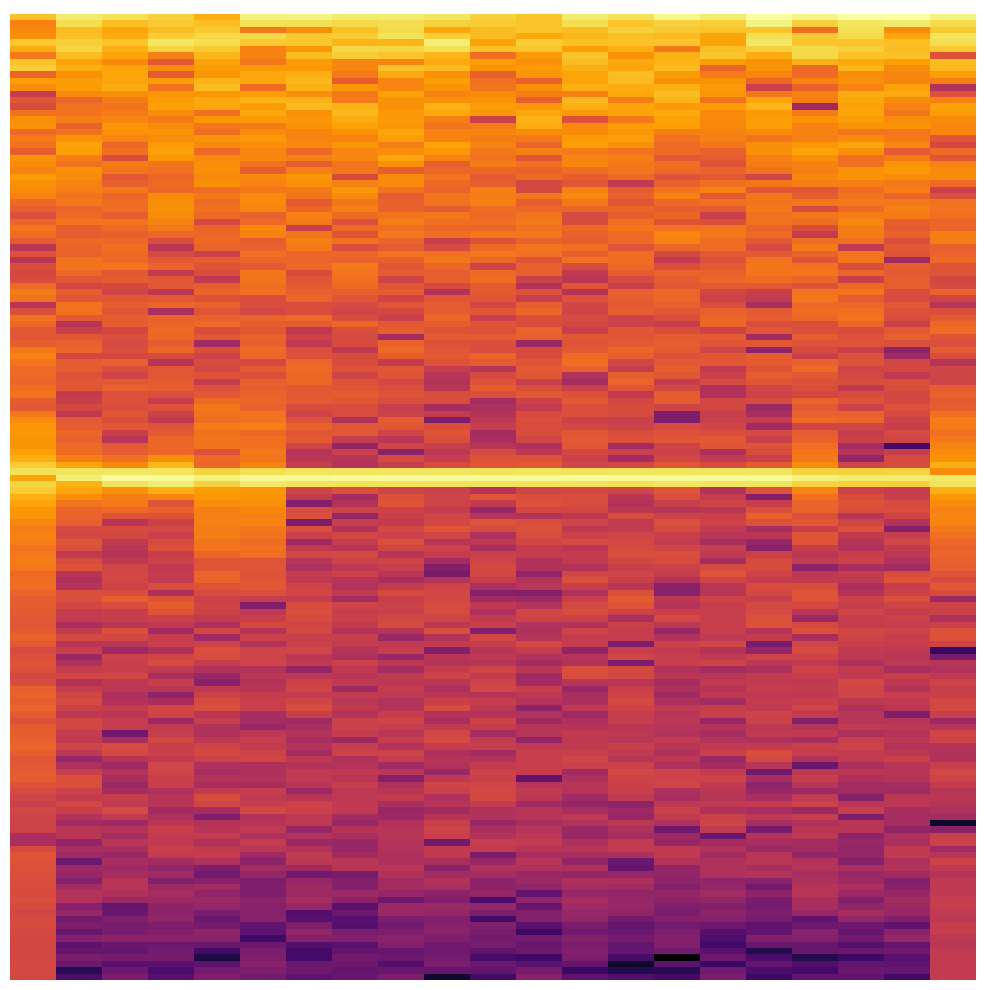

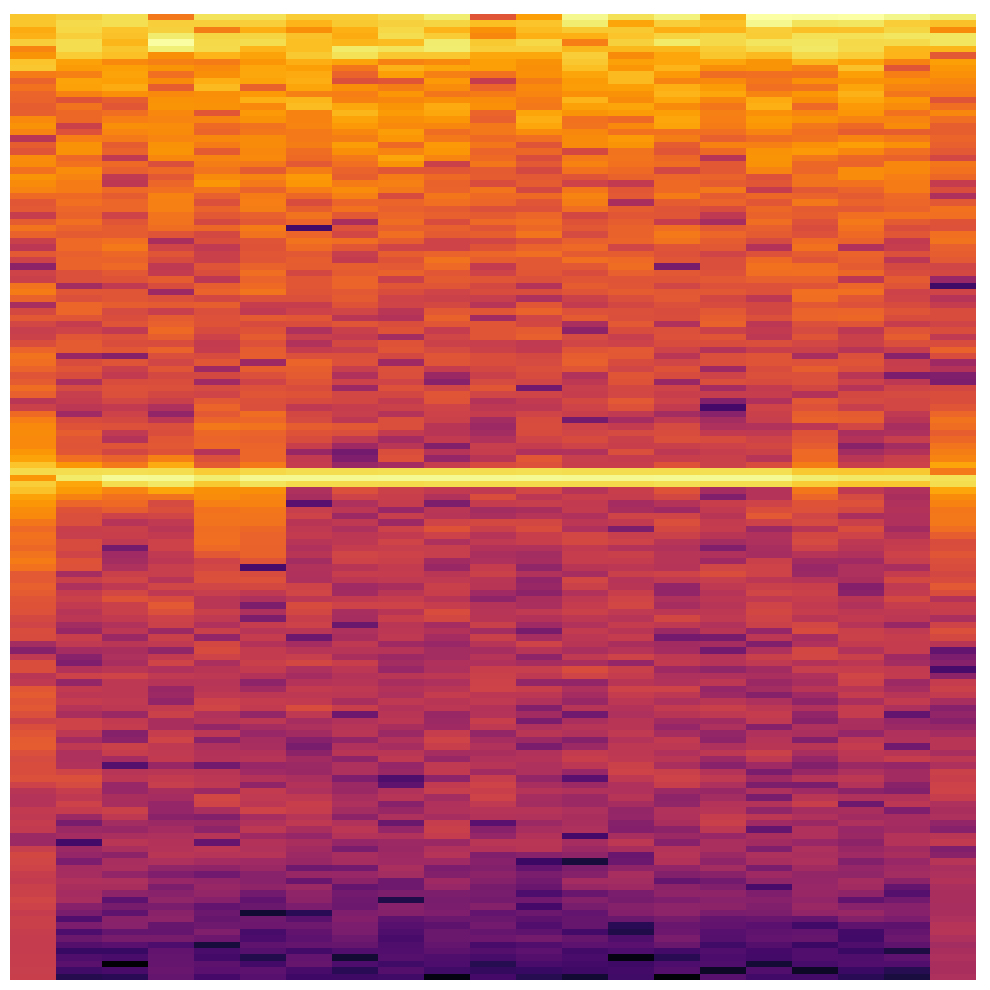

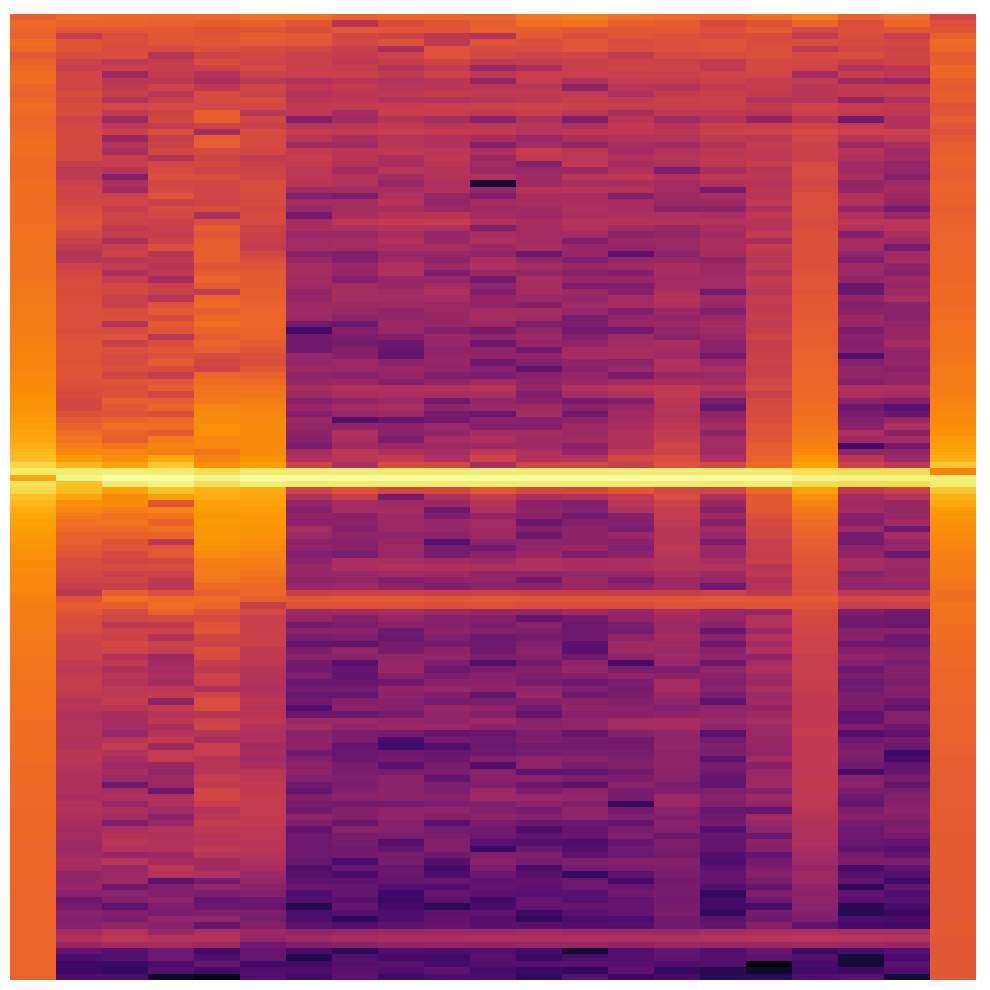

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

EEG_data = np.load(
    os.path.join(config["DATA_DIR"], "dev_x_not_mmap.npy"), mmap_mode="r"
)

x = torch.from_numpy(EEG_data[0, :, :].copy())

window = torch.hann_window(300)

for channel in range(3):
    stft_temp = torch.log(
        torch.abs(
            torch.stft(
                input=x[:, channel].float(),
                n_fft=300,
                hop_length=150,
                win_length=300,
                window=window,
                center=True,
                normalized=True,
                onesided=True,
                return_complex=True,
            )
        )
        + 1e-8
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(
        stft_temp,
        ax=ax,
        cmap="inferno",
        cbar=False,
        cbar_kws={"label": "dB"},
        linewidths=0,
    )

    for child in ax.get_children():
        if isinstance(child, patches.Rectangle):
            child.set_width(child.get_width() + 0.005)
            child.set_height(child.get_height() + 0.005)

    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Export to PDF in vectorized format
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            folder_to_save_figure, f"stft_pre_50hz_channel_{channel}_figure.svg"
        ),
        format="svg",
    )

In [5]:
class NpyDatasetSTFT(Dataset):
    def __init__(
        self,
        x_filename,
        y_filename,
        frequency_scrambling=False,
        frequency_index_scrambler=None,
        frequency_scrambling_type="permuted",
    ):
        super(NpyDatasetSTFT, self).__init__()

        self._x = np.load(x_filename, mmap_mode="r")
        self.y = torch.from_numpy(np.load(y_filename)).long()
        self.frequency_index_scrambler = frequency_index_scrambler
        self.frequency_scrambling_type = frequency_scrambling_type

        self.window = torch.hann_window(300)
        lower_freq = 55  # 60 - 5
        upper_freq = 65  # 60 + 5
        self.lower_bin = int(lower_freq * 150 / 125)
        self.upper_bin = int(upper_freq * 150 / 125)

        self.x = [None] * len(self._x)
        for i in range(len(self.x)):
            if i in [int(len(self.x) * j / 100) for j in range(0, 101, 10)]:
                print(int(i / len(self.x) * 100))

            x_temp = torch.tensor(self._x[i]).float().T
            self.x[i] = torch.log(
                torch.abs(
                    torch.stft(
                        input=x_temp,
                        n_fft=300,
                        hop_length=150,
                        win_length=300,
                        window=self.window,
                        center=True,
                        normalized=True,
                        onesided=True,
                        return_complex=True,
                    )
                )
                + 1e-8
            ).half()
            self.x[i] = torch.mean(self.x[i], dim=0)
            self.x[i] = torch.cat(
                (self.x[i][1 : self.lower_bin, :], self.x[i][self.upper_bin :, :]),
                dim=0,
            )  # x[i] is of dimension [ n_freq , n_time]

        del self._x

        self.x = torch.stack(self.x, dim=0).float()

        if frequency_scrambling:
            if self.frequency_index_scrambler is None:
                if self.frequency_scrambling_type == "permuted":
                    self.frequency_index_scrambler = [
                        None,
                        torch.randperm(self.x.shape[1]),
                        torch.randperm(self.x.shape[2]),
                    ]
                elif self.frequency_scrambling_type == "random":
                    print("random")
                    self.frequency_index_scrambler = torch.randperm(
                        self.x.shape[1] * self.x.shape[2]
                    )

            self.update_frequency_scrambler(self.frequency_index_scrambler)
        gc.collect()

    def update_frequency_scrambler(self, frequency_index_scrambler):
        self.frequency_index_scrambler = frequency_index_scrambler
        if self.frequency_scrambling_type == "permuted":
            self.x = self.x[:, :, self.frequency_index_scrambler[2]][
                :, self.frequency_index_scrambler[1], :
            ]
        elif self.frequency_scrambling_type == "random":
            self.x = self.x.flatten(start_dim=1)[
                :, self.frequency_index_scrambler
            ].reshape((self.x.shape[0], self.x.shape[1], self.x.shape[2]))

    def __getitem__(self, index):
        # Load data and target
        x_data = self.x[index]
        y_data = self.y[index]

        return x_data, y_data

    def __len__(self):
        return len(self.x)

In [6]:
task_datasets = {}

# Datasets definition for each task.
for task in range(2):
    if task == 0:
        task_datasets[f"test_{task}"] = NpyDatasetSTFT(
            os.path.join(config["DATA_DIR"], "dev_x_not_mmap.npy"),
            os.path.join(config["DATA_DIR"], "dev_y_not_mmap.npy"),
            frequency_scrambling=False,
        )

    else:
        task_datasets[f"test_{task}"] = NpyDatasetSTFT(
            os.path.join(config["DATA_DIR"], "dev_x_not_mmap.npy"),
            os.path.join(config["DATA_DIR"], "dev_y_not_mmap.npy"),
            frequency_scrambling=True,
            frequency_scrambling_type="random",
        )

0
9
19
29
39
49
59
69
79
89
0
9
19
29
39
49
59
69
79
89
random


#### STFT without scrambling


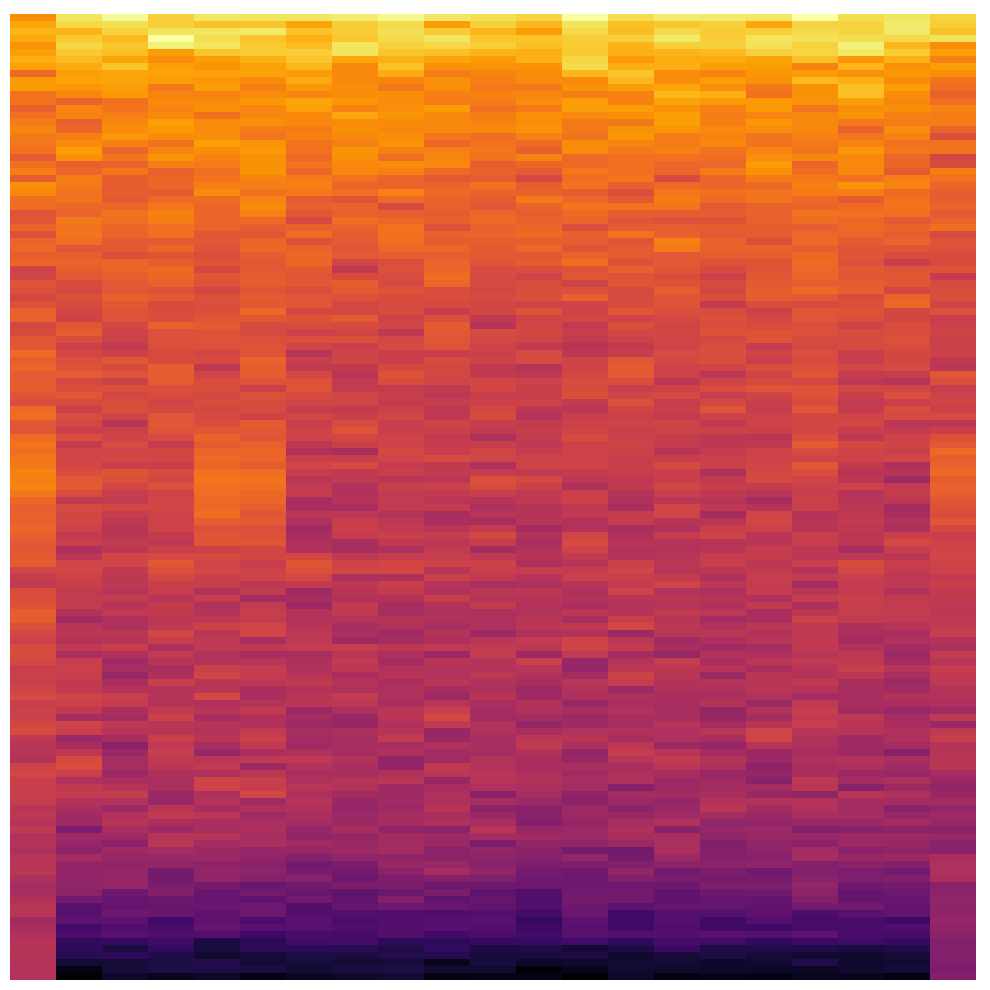

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    task_datasets["test_0"][0][0],
    ax=ax,
    cmap="inferno",
    cbar=False,
    cbar_kws={"label": "dB"},
    linewidths=0,
)

for child in ax.get_children():
    if isinstance(child, patches.Rectangle):
        child.set_width(child.get_width() + 0.005)
        child.set_height(child.get_height() + 0.005)

# remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Export to PDF in vectorized format
plt.tight_layout()
plt.savefig(
    os.path.join(folder_to_save_figure, "stft_averaged_figure.svg"), format="svg"
)

In [8]:
task_datasets["test_0"][0][0].shape

torch.Size([138, 21])

#### STFT with scrambling


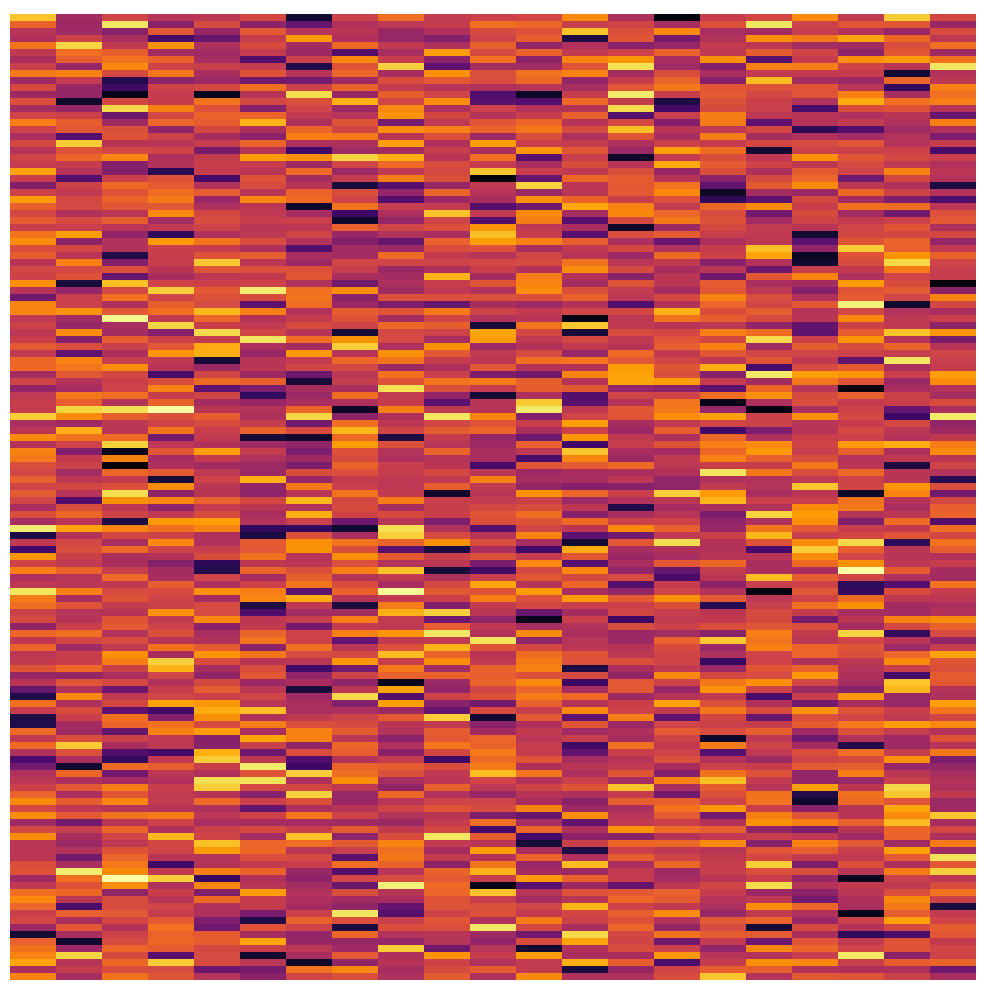

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    task_datasets["test_1"][0][0],
    ax=ax,
    cmap="inferno",
    cbar=False,
    cbar_kws={"label": "dB"},
    linewidths=0,
)

for child in ax.get_children():
    if isinstance(child, patches.Rectangle):
        child.set_width(child.get_width() + 0.005)
        child.set_height(child.get_height() + 0.005)

# remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Export to csv in vectorized format
plt.tight_layout()
plt.savefig(
    os.path.join(folder_to_save_figure, "stft_scrambled_figure.pdf"), format="pdf"
)

#### STFT Normal and Scramble


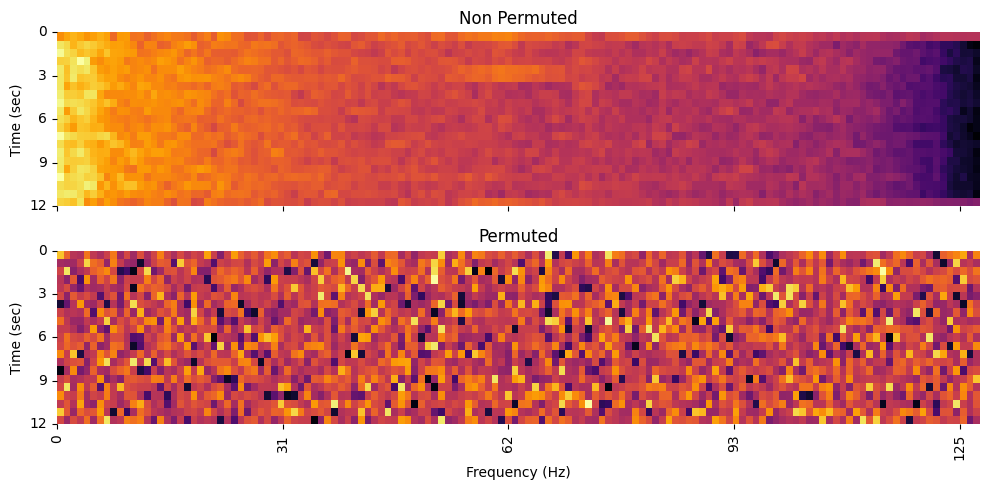

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sns.heatmap(
    task_datasets["test_0"][0][0].transpose(0, 1),
    ax=ax[0],
    cmap="inferno",
    cbar=False,
    cbar_kws={"label": "dB"},
)
ax[0].set_title("Non Permuted")

ax[0].set_xticks(np.linspace(0, 135, 5))
ax[0].set_xticklabels([""] * 5)

ax[0].set_ylabel("Time (sec)")
ax[0].set_yticks(np.linspace(0, 21, 5))
ax[0].set_yticklabels(np.linspace(0, 12, 5).astype(int))

sns.heatmap(
    task_datasets["test_1"][0][0].transpose(0, 1),
    ax=ax[1],
    cmap="inferno",
    cbar=False,
    cbar_kws={"label": "dB"},
)

ax[1].set_title("Permuted")

ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xticks(np.linspace(0, 135, 5))
ax[1].set_xticklabels(np.linspace(0, 125, 5).astype(int))

ax[1].set_ylabel("Time (sec)")
ax[1].set_yticks(np.linspace(0, 21, 5))
ax[1].set_yticklabels(np.linspace(0, 12, 5).astype(int))

# Export to PDF in vectorized format
plt.tight_layout()
plt.savefig(
    os.path.join(folder_to_save_figure, "stft_normal_scrambled_figure.pdf"),
    format="pdf",
)

## Training results


In [ ]:
import sys
import os

sys.path.append(os.path.join("..", "src"))

import numpy as np
import matplotlib.pyplot as plt

import wandb

os.environ["WANDB_SILENT"] = "true"

### Synthetic Data results


In [ ]:
PROJECT_NAME = "PermutedTaskTUH"
GROUP_NAME = "5tasks_2x4096"
NUMBER_OF_TASKs = 5
META_TO_PLOT = [0, 30, 60]

1. Retrieving the runs_ids from the training with specified meta data


In [ ]:
api = wandb.Api()

# replace 'username' with your wandb username and 'project-name' with your project name
runs = api.runs(f"username/{PROJECT_NAME}")

# get group names and run ids for each group
meta_runs = {}
for run_id, run in enumerate(runs):
    selected_group = run.group == GROUP_NAME
    selected_number_task = run.config["NUMBER_OF_TASKS"] == NUMBER_OF_TASKs
    if selected_group and selected_number_task:
        meta_run = run.config["META"]
        meta_selected = meta_run in META_TO_PLOT
        if meta_selected:
            if meta_run not in meta_runs.keys():
                meta_runs[meta_run] = [run_id]
            else:
                meta_runs[meta_run].append(run_id)

# print number of run per meta
number_run_total = 0
for meta_run in meta_runs.keys():
    number_run_total += len(meta_runs[meta_run])
    print(f"Meta: {meta_run} - Number of runs: {len(meta_runs[meta_run])}")
print(f"Total number of runs: {number_run_total}")

Meta: 60 - Number of runs: 5
Meta: 30 - Number of runs: 5
Meta: 0 - Number of runs: 5
Total number of runs: 15


2. Retrieving the data from the specified runs


In [ ]:
# will be of the shape
# {meta_task_key: [auc_task_0:list of number,
#                  auc_task_1:list of number, ...]}

meta_runs_auc = {}
meta_runs_acc = {}  # same

for meta, list_run_id in meta_runs.items():
    for run_id in list_run_id:
        if any(
            f"Accuracy_test_{x}" in runs[run_id].history().keys() for x in range(5)
        ) and any(f"AUC_test_{x}" in runs[run_id].history().keys() for x in range(5)):
            for synthetic_task in range(0, NUMBER_OF_TASKs):
                meta_task_key = str(meta) + "_" + str(synthetic_task)
                if meta_task_key not in meta_runs_auc.keys():
                    meta_runs_auc[meta_task_key] = [
                        runs[run_id].history()[f"AUC_test_{synthetic_task}"]
                    ]
                    meta_runs_acc[meta_task_key] = [
                        runs[run_id].history()[f"Accuracy_test_{synthetic_task}"]
                    ]
                else:
                    meta_runs_auc[meta_task_key].append(
                        runs[run_id].history()[f"AUC_test_{synthetic_task}"]
                    )
                    meta_runs_acc[meta_task_key].append(
                        runs[run_id].history()[f"Accuracy_test_{synthetic_task}"]
                    )

# computing average and std of metrics for each meta

meta_runs_auc_mean = {}
meta_runs_auc_std = {}

meta_runs_acc_mean = {}
meta_runs_acc_std = {}

for meta_task_key in meta_runs_auc.keys():
    meta_runs_auc_mean[meta_task_key] = np.mean(
        np.array(meta_runs_auc[meta_task_key]), axis=0
    )
    meta_runs_auc_std[meta_task_key] = np.std(
        np.array(meta_runs_auc[meta_task_key]), axis=0
    )
for meta_task_key in meta_runs_acc.keys():
    meta_runs_acc_mean[meta_task_key] = np.mean(
        np.array(meta_runs_acc[meta_task_key]), axis=0
    )
    meta_runs_acc_std[meta_task_key] = np.std(
        np.array(meta_runs_acc[meta_task_key]), axis=0
    )

3. Plotting the retrieved data


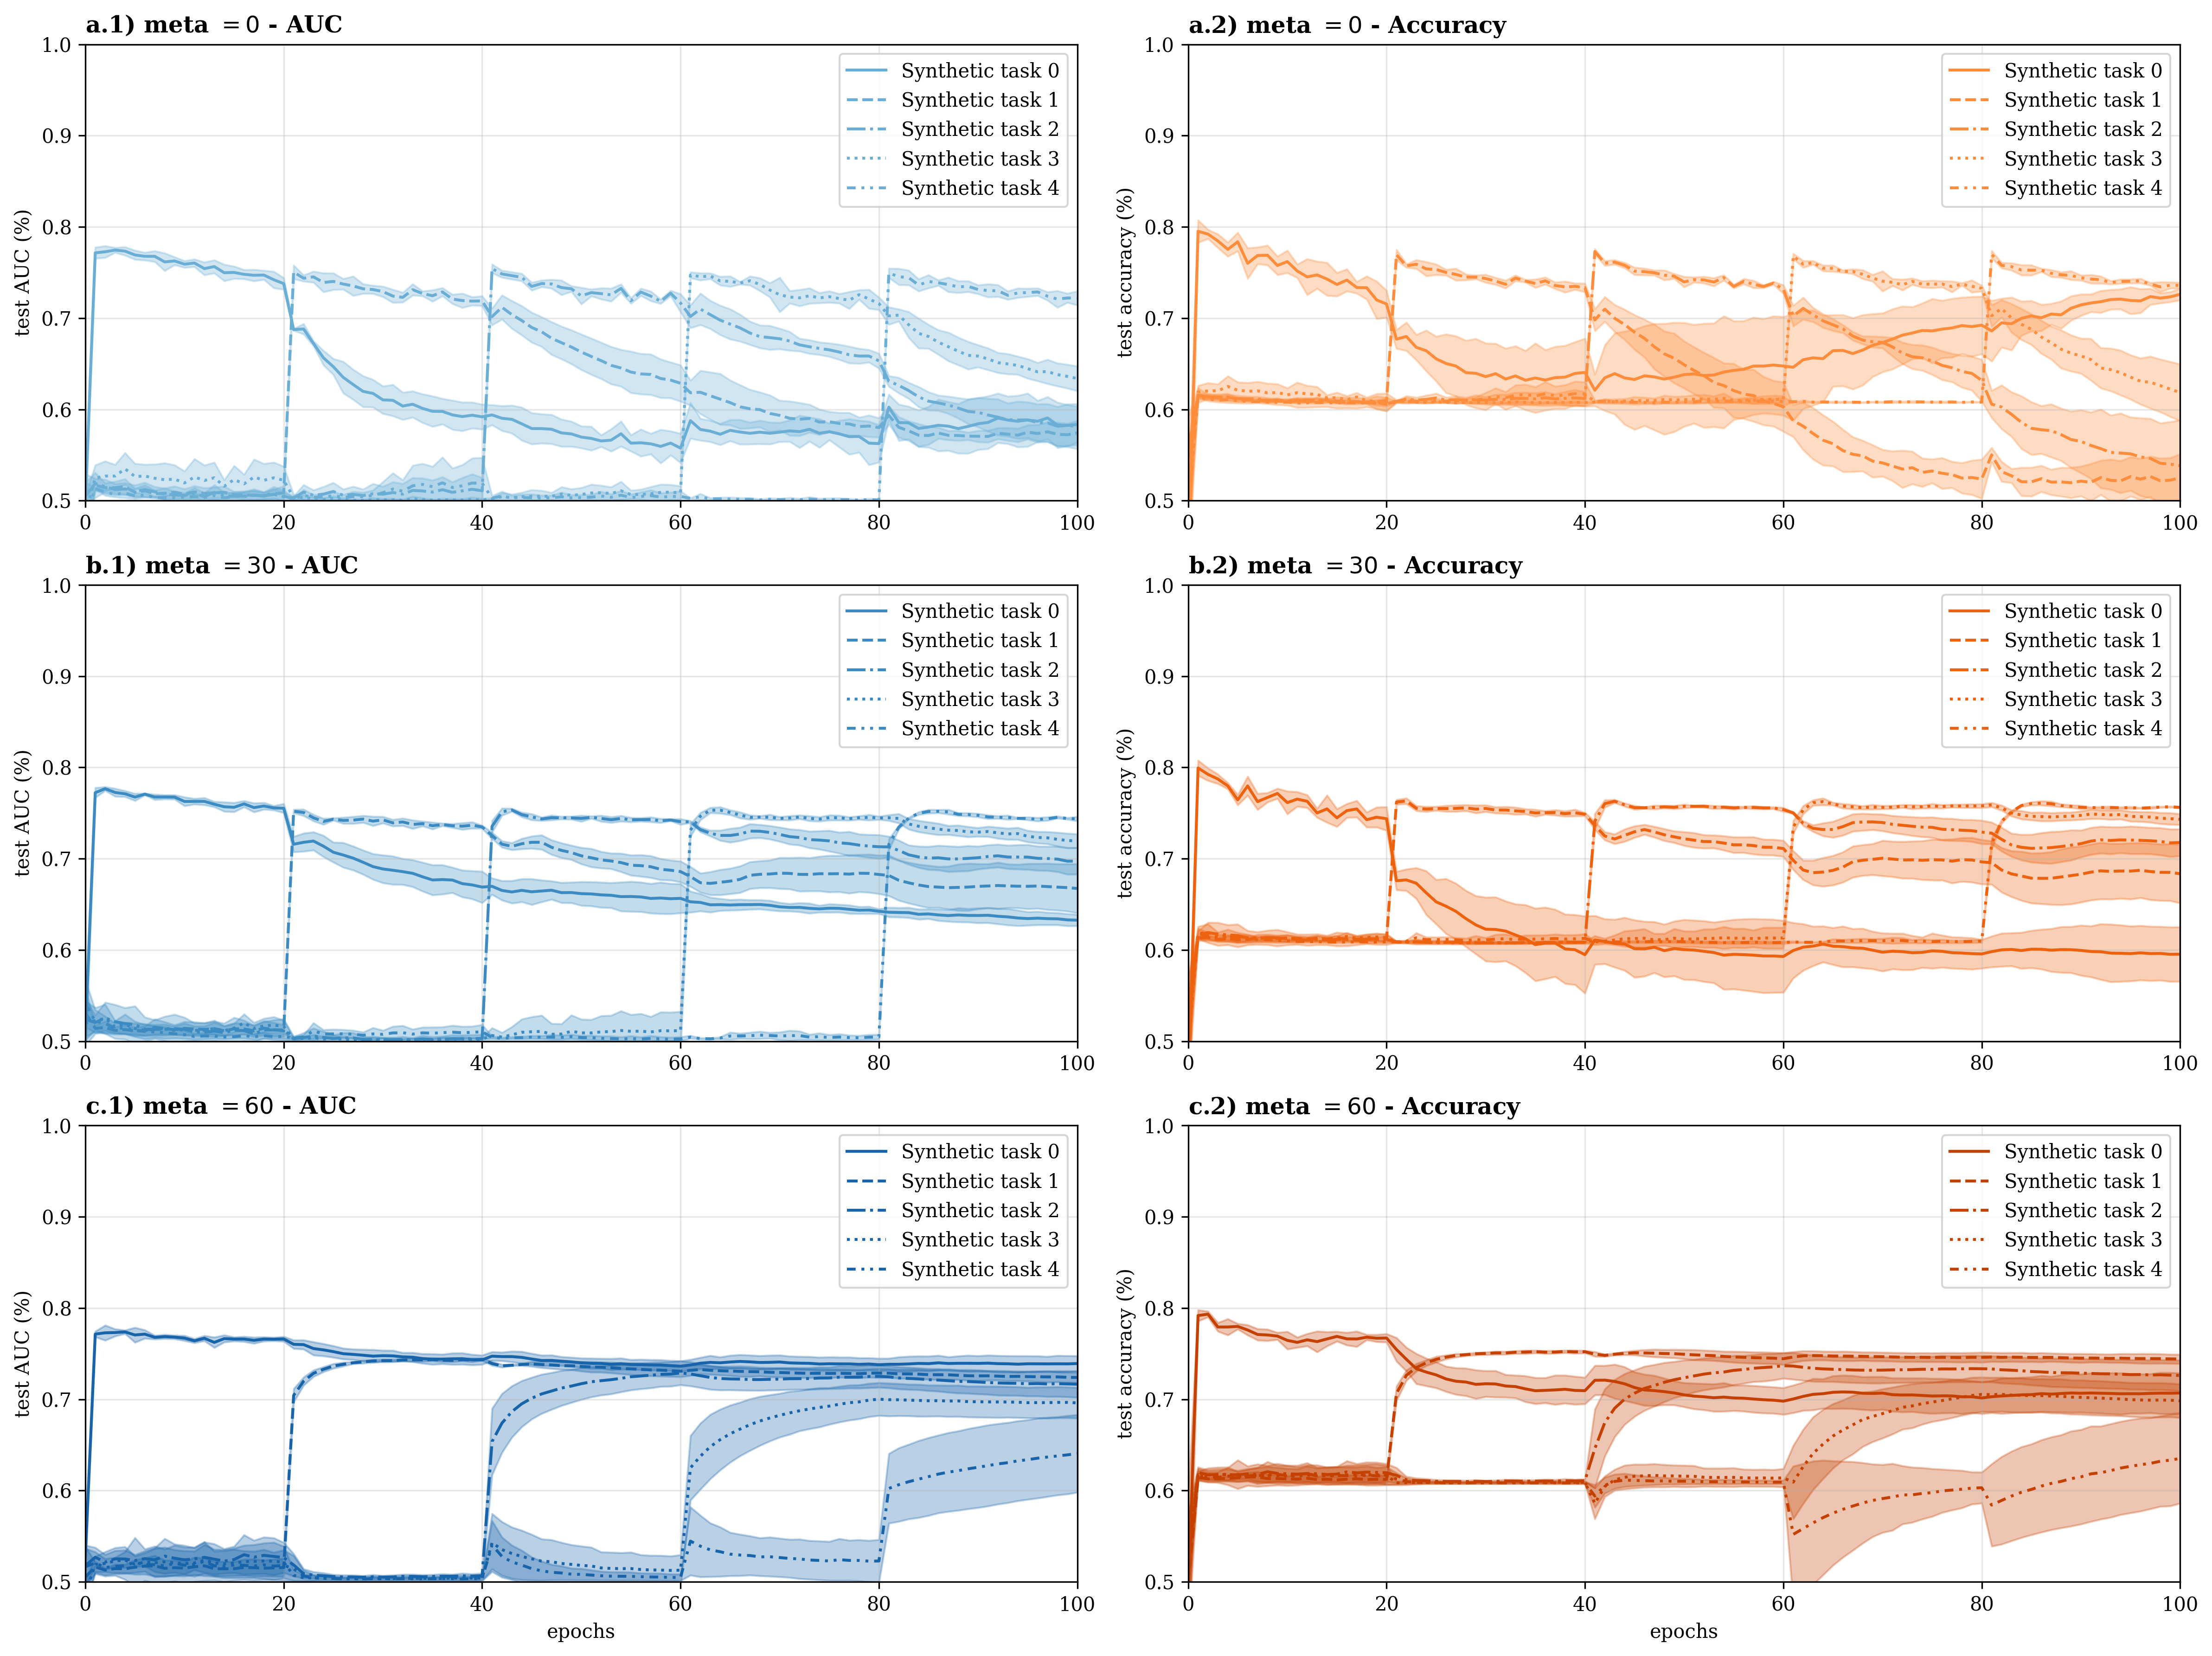

In [ ]:
# plotting
plt.rcParams["font.family"] = "Arial"
number_meta = len(meta_runs.keys())

fig, ax = plt.subplots(number_meta, 2, figsize=(16, 4 * number_meta), dpi=300)
ax_index = 0

subplot_title = [chr(i) for i in range(97, 97 + number_meta)]

line_styles = ["-", "--", "-.", ":", (0, (3, 2, 1, 2, 1, 2))]

# Generate color array with values between 0 and 1 (corresponds to hsv colormap)
color_values = (np.array(
    [0, 0.1, 0.275, 0.575, 0.6667]
)) 

# save last datapoint of each meta for task = 0 for the stream figures

last_datapoint_auc = {}
last_datapoint_acc = {}

last_std_auc = {}
last_std_acc = {}

# Get the colormap
cmap_auc = plt.cm.hsv 
cmap_acc = plt.cm.hsv 

# Get the colors from the colormap
color_auc = [cmap_auc(value) for value in color_values]
color_acc = [cmap_acc(value) for value in color_values]


for ax_index, meta in enumerate(sorted(meta_runs.keys())):
    for task_index in range(NUMBER_OF_TASKs):
        meta_task_key = str(meta) + "_" + str(task_index)

        # plot AUC

        mean = meta_runs_auc_mean[meta_task_key]
        std = meta_runs_auc_std[meta_task_key]

        ax[ax_index, 0].plot(
            range(len(mean)),
            mean,
            label=f"Synthetic dataset {task_index}",
            linestyle=line_styles[task_index],
            c=color_auc[task_index], # prev. [ax_index]
        )
        ax[ax_index, 0].fill_between(
            range(len(mean)),
            mean - std,
            mean + std,
            alpha=0.3,
            color=color_auc[task_index], # prev. [ax_index]
        )
        
        ax[ax_index, 0].tick_params(axis='both', labelsize=20)
        
        if task_index == 0:
            last_datapoint_auc[meta] = mean[-1]
            last_std_auc[meta] = std[-1]
            
        
        # plot ACC

        mean = meta_runs_acc_mean[meta_task_key]
        std = meta_runs_acc_std[meta_task_key]

        ax[ax_index, 1].plot(
            range(len(mean)),
            mean,
            label=f"Synthetic task {task_index}",
            linestyle=line_styles[task_index],
            c=color_acc[task_index], # prev. [ax_index]
        )
        ax[ax_index, 1].fill_between(
            range(len(mean)),
            mean - std,
            mean + std,
            alpha=0.3,
            color=color_acc[task_index], # prev. [ax_index]
        )
        ax[ax_index, 1].tick_params(axis='both', labelsize=20)


    
        if task_index == 0:
            last_datapoint_acc[meta] = mean[-1]
            last_std_acc[meta] = std[-1]

        if ax_index == number_meta - 1:
            ax[ax_index, 0].set_xlabel("Test AUC")
            ax[ax_index, 1].set_xlabel("Test Accuracy")
            
        
    metric = ["AUC", "Accuracy"]
    for colum_index in [0, 1]:
        ylabel = "Test AUC" if colum_index == 0 else "Test Accuracy"
        ax[ax_index, colum_index].set_ylabel(ylabel, fontsize=24)

   
        
         # adjust ylabel of second column 
        ax[ax_index, 1].yaxis.set_label_position("right") # moves ylabel in column 2 to the right side
        ax[ax_index, 1].yaxis.tick_right() # moves ytick in column to the right side
        ax[ax_index, 1].set_ylabel(ylabel, rotation=270, fontsize=24) # flips ylabel in column 2 
        ax[ax_index, 1].yaxis.set_label_coords(1.1, 0.5) # adjusts position of ylabel in column 2 (arbitrary coords)

        ax[ax_index, colum_index].set_ylim(0.5, 0.825)
        ax[ax_index, colum_index].set_xlim(0, 100)
        ax[ax_index, colum_index].set_title(
 
        f"{subplot_title[ax_index]}) meta $= {meta}$ ",
        loc="left", fontsize=24,
        x = 0.025,
        y = 0.875 
        )


        ax[ax_index, colum_index].grid(alpha=0.3)
        ax[ax_index, colum_index].xaxis.set_ticks(
            range(0, len(mean), 20)
        )  # Assuming len(mean) gives the number of epochs, adjust the step (10) as needed

# Removing Accuracy plots (if only looking at AUC)
#ax[0,1].remove()
#ax[1,1].remove()
#ax[2,1].remove()
##
for colum_index in [0, 1]:
    ax[-1, colum_index].set_xlabel("Epochs", fontsize=24)  # Set x-axis label only for the last row
    ax[0, colum_index].set_xticklabels([]) # Remove x-axis from first subplot
    ax[1, colum_index].set_xticklabels([]) # Remove x-axis from second subplot

  # Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Limit the legend to the first four items
limited_handles = handles[:5]
labels[0] = "Original dataset 0"
limited_labels = labels[:5]

# Create the legend with the limited handles and labels
legend = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.075, 1.1), ncol=2,frameon=True, facecolor='white', fontsize='xx-large') # create legend for entire plot
legend.get_frame().set_edgecolor('white')

for handle in legend.legend_handles:
    handle.set_linewidth(2.5)

plt.tight_layout()
plt.savefig(
    os.path.join(folder_to_save_figure, "synthetic_task_learning.pdf"), format="pdf"
)

4. Computing the average AUC and Acc over the different tasks


In [ ]:
epoch_total = meta_runs_auc_mean[sorted(meta_runs_auc_mean.keys())[0]].shape[0]

AUC_mean = {}
Accuracy_mean = {}


for meta in sorted(meta_runs.keys()):
    if meta not in AUC_mean.keys():
        AUC_mean[meta] = 0
        Accuracy_mean[meta] = 0

    for epoch in range(1, epoch_total):
        number_task_learned = (epoch - 1) // 20
        to_add_to_auc_mean = 0
        to_add_to_acc_mean = 0
        for number_task in range(0, number_task_learned + 1):
            meta_task_key = str(meta) + "_" + str(number_task)
            to_add_to_auc_mean += meta_runs_auc_mean[meta_task_key][epoch - 1]
            to_add_to_acc_mean += meta_runs_acc_mean[meta_task_key][epoch - 1]
        to_add_to_auc_mean /= number_task_learned + 1
        to_add_to_acc_mean /= number_task_learned + 1
        AUC_mean[meta] += to_add_to_auc_mean
        Accuracy_mean[meta] += to_add_to_acc_mean
    AUC_mean[meta] /= epoch_total - 1
    Accuracy_mean[meta] /= epoch_total - 1

    print(f"Meta: {meta} - AUC: {AUC_mean[meta]} - Accuracy: {Accuracy_mean[meta]}")

Meta: 0 - AUC: 0.6699155812856352 - Accuracy: 0.6828080603335431
Meta: 30 - AUC: 0.7113330875254349 - Accuracy: 0.7053704179196106
Meta: 60 - AUC: 0.727071700146005 - Accuracy: 0.7248047166830354


### Stream Learning results


In [ ]:
PROJECT_NAME = "StreamTUH"
GROUP_NAME = "2Lx4096"
META_TO_PLOT = [0, 60]

1. Retrieving the runs_ids from the training with specified meta data


In [ ]:
api = wandb.Api()

# replace 'username' with your wandb username and 'project-name' with your project name
runs = api.runs(f"username/{PROJECT_NAME}")

# get group names and run ids for each group
meta_runs = {}
for run_id, run in enumerate(runs):
    selected_group = run.group == GROUP_NAME
    if selected_group:
        meta_run = run.config["META"]
        meta_selected = meta_run in META_TO_PLOT
        if meta_selected:
            if meta_run not in meta_runs.keys():
                meta_runs[meta_run] = [run_id]
            else:
                meta_runs[meta_run].append(run_id)

# print number of run per meta
number_run_total = 0
for meta_run in meta_runs.keys():
    number_run_total += len(meta_runs[meta_run])
    print(f"Meta: {meta_run} - Number of runs: {len(meta_runs[meta_run])}")
print(f"Total number of runs: {number_run_total}")

Meta: 60 - Number of runs: 6
Meta: 0 - Number of runs: 6
Total number of runs: 12


2. Retrieving the data from the specified runs


In [ ]:
# will be of the shape
# {meta: auc:list of number}

meta_runs_auc = {}
meta_runs_acc = {}  # same

for meta, list_run_id in meta_runs.items():
    for run_id in list_run_id:
        if (f"Accuracy_test" in runs[run_id].history().keys()) and (
            f"AUC_test" in runs[run_id].history().keys()
        ):
            if meta not in meta_runs_auc.keys():
                meta_runs_auc[meta] = [runs[run_id].history()[f"AUC_test"]]
                meta_runs_acc[meta] = [runs[run_id].history()[f"Accuracy_test"]]
            else:
                meta_runs_auc[meta].append(runs[run_id].history()[f"AUC_test"])
                meta_runs_acc[meta].append(runs[run_id].history()[f"Accuracy_test"])

# computing average and std of metrics for each meta

meta_runs_auc_mean = {}
meta_runs_auc_std = {}

meta_runs_acc_mean = {}
meta_runs_acc_std = {}

for meta in meta_runs_auc.keys():
    meta_runs_auc_mean[meta] = np.mean(np.array(meta_runs_auc[meta]), axis=0)
    meta_runs_auc_std[meta] = np.std(np.array(meta_runs_auc[meta]), axis=0)
for meta in meta_runs_acc.keys():
    meta_runs_acc_mean[meta] = np.mean(np.array(meta_runs_acc[meta]), axis=0)
    meta_runs_acc_std[meta] = np.std(np.array(meta_runs_acc[meta]), axis=0)

3. Retrieving reference point for training with

In [ ]:
# get group names and run ids for each group
meta_runs = {}
for run_id, run in enumerate(runs):
    selected_group = run.group == GROUP_NAME_REF
    if selected_group:
        meta_run = run.config["META"]
        number_subset_run = run.config["NUMBER_SUBSET"]
        meta_selected = meta_run in META_TO_PLOT
        if meta_selected:
            if meta_run not in meta_runs.keys():
                meta_runs[meta_run] = [run_id]
            else:
                meta_runs[meta_run].append(run_id)

# print number of run per meta
number_run_total = 0
for meta_run in meta_runs.keys():
    number_run_total += len(meta_runs[meta_run])
    print(f"Meta: {meta_run} - Number of runs: {len(meta_runs[meta_run])}")
print(f"Total number of runs: {number_run_total}")


# will be of the shape
# {meta: auc:list of number}

meta_runs_auc = {}
meta_runs_acc = {}  # same

for meta, list_run_id in meta_runs.items():
    for run_id in list_run_id:
        if (f"Accuracy_test" in runs[run_id].history().keys()) and (
            f"AUC_test" in runs[run_id].history().keys()
        ):
            if meta not in meta_runs_auc.keys():
                meta_runs_auc[meta] = [runs[run_id].history()[f"AUC_test"]]
                meta_runs_acc[meta] = [runs[run_id].history()[f"Accuracy_test"]]
            else:
                meta_runs_auc[meta].append(runs[run_id].history()[f"AUC_test"])
                meta_runs_acc[meta].append(runs[run_id].history()[f"Accuracy_test"])

# computing average and std of metrics for each meta

meta_runs_auc_mean_ref = {}
meta_runs_auc_std_ref = {}

meta_runs_acc_mean_ref = {}
meta_runs_acc_std_ref = {}

for meta in meta_runs_auc.keys():
    meta_runs_auc_mean_ref[meta] = np.mean(np.array(meta_runs_auc[meta]), axis=0)
    meta_runs_auc_std_ref[meta] = np.std(np.array(meta_runs_auc[meta]), axis=0)
for meta in meta_runs_acc.keys():
    meta_runs_acc_mean_ref[meta] = np.mean(np.array(meta_runs_acc[meta]), axis=0)
    meta_runs_acc_std_ref[meta] = np.std(np.array(meta_runs_acc[meta]), axis=0)

4. Retrieving the data for full precision network

stream learning results

In [ ]:
runs = api.runs(f"thomas-bersani-veroni/{PROJECT_NAME}")
# get group names and run ids for each group
meta_runs = {}
for run_id, run in enumerate(runs):
    selected_group = run.group == Group_NAME_FULLPRE
    if selected_group:
        meta_run = run.config["META"]
        number_subset_run = run.config["NUMBER_SUBSET"]
        meta_selected = meta_run in META_TO_PLOT and number_subset_run == 300
        if meta_selected:
            if meta_run not in meta_runs.keys():
                meta_runs[meta_run] = [run_id]
            else:
                meta_runs[meta_run].append(run_id)

# print number of run per meta
number_run_total = 0
for meta_run in meta_runs.keys():
    number_run_total += len(meta_runs[meta_run])
    print(f"Meta: {meta_run} - Number of runs: {len(meta_runs[meta_run])}")
print(f"Total number of runs: {number_run_total}")


# will be of the shape
# {meta: auc:list of number}

meta_runs_auc = {}
meta_runs_acc = {}  # same

for meta, list_run_id in meta_runs.items():
    for run_id in list_run_id:
        if (f"Accuracy_test" in runs[run_id].history().keys()) and (
            f"AUC_test" in runs[run_id].history().keys()
        ):
            if meta not in meta_runs_auc.keys():
                meta_runs_auc[meta] = [runs[run_id].history()[f"AUC_test"]]
                meta_runs_acc[meta] = [runs[run_id].history()[f"Accuracy_test"]]
            else:
                meta_runs_auc[meta].append(runs[run_id].history()[f"AUC_test"])
                meta_runs_acc[meta].append(runs[run_id].history()[f"Accuracy_test"])

# computing average and std of metrics for each meta

meta_runs_auc_mean_fullpre = {}
meta_runs_auc_std_fullpre = {}

meta_runs_acc_mean_fullpre = {}
meta_runs_acc_std_fullpre = {}

for meta in meta_runs_auc.keys():
    meta_runs_auc_mean_fullpre[meta] = np.mean(np.array(meta_runs_auc[meta]), axis=0)
    meta_runs_auc_std_fullpre[meta] = np.std(np.array(meta_runs_auc[meta]), axis=0)
for meta in meta_runs_acc.keys():
    meta_runs_acc_mean_fullpre[meta] = np.mean(np.array(meta_runs_acc[meta]), axis=0)
    meta_runs_acc_std_fullpre[meta] = np.std(np.array(meta_runs_acc[meta]), axis=0)

reference results for the full dataset training for the full precision network

In [ ]:
runs = api.runs(f"username/{PROJECT_NAME}")
# get group names and run ids for each group
meta_runs = {}
for run_id, run in enumerate(runs):
    selected_group = run.group == Group_NAME_FULLPRE
    if selected_group:
        meta_run = run.config["META"]
        number_subset_run = run.config["NUMBER_SUBSET"]
        meta_selected = meta_run in META_TO_PLOT and number_subset_run == 1
        if meta_selected:
            if meta_run not in meta_runs.keys():
                meta_runs[meta_run] = [run_id]
            else:
                meta_runs[meta_run].append(run_id)

# print number of run per meta
number_run_total = 0
for meta_run in meta_runs.keys():
    number_run_total += len(meta_runs[meta_run])
    print(f"Meta: {meta_run} - Number of runs: {len(meta_runs[meta_run])}")
print(f"Total number of runs: {number_run_total}")

# will be of the shape
# {meta: auc:list of number}

meta_runs_auc = {}
meta_runs_acc = {}  # same

for meta, list_run_id in meta_runs.items():
    for run_id in list_run_id:
        if (f"Accuracy_test" in runs[run_id].history().keys()) and (
            f"AUC_test" in runs[run_id].history().keys()
        ):
            if meta not in meta_runs_auc.keys():
                meta_runs_auc[meta] = [runs[run_id].history()[f"AUC_test"]]
                meta_runs_acc[meta] = [runs[run_id].history()[f"Accuracy_test"]]
            else:
                meta_runs_auc[meta].append(runs[run_id].history()[f"AUC_test"])
                meta_runs_acc[meta].append(runs[run_id].history()[f"Accuracy_test"])

# computing average and std of metrics for each meta

meta_runs_auc_mean_fullpre_ref = {}
meta_runs_auc_std_fullpre_ref = {}

meta_runs_acc_mean_fullpre_ref = {}
meta_runs_acc_std_fullpre_ref = {}

for meta in meta_runs_auc.keys():
    meta_runs_auc_mean_fullpre_ref[meta] = np.mean(
        np.array(meta_runs_auc[meta]), axis=0
    )
    meta_runs_auc_std_fullpre_ref[meta] = np.std(np.array(meta_runs_auc[meta]), axis=0)
for meta in meta_runs_acc.keys():
    meta_runs_acc_mean_fullpre_ref[meta] = np.mean(
        np.array(meta_runs_acc[meta]), axis=0
    )
    meta_runs_acc_std_fullpre_ref[meta] = np.std(np.array(meta_runs_acc[meta]), axis=0)

5. Plotting the retrieved data


C:\Users\Thomas\AppData\Local\Temp\ipykernel_27248\3342577820.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[colum_index].set_yticklabels(


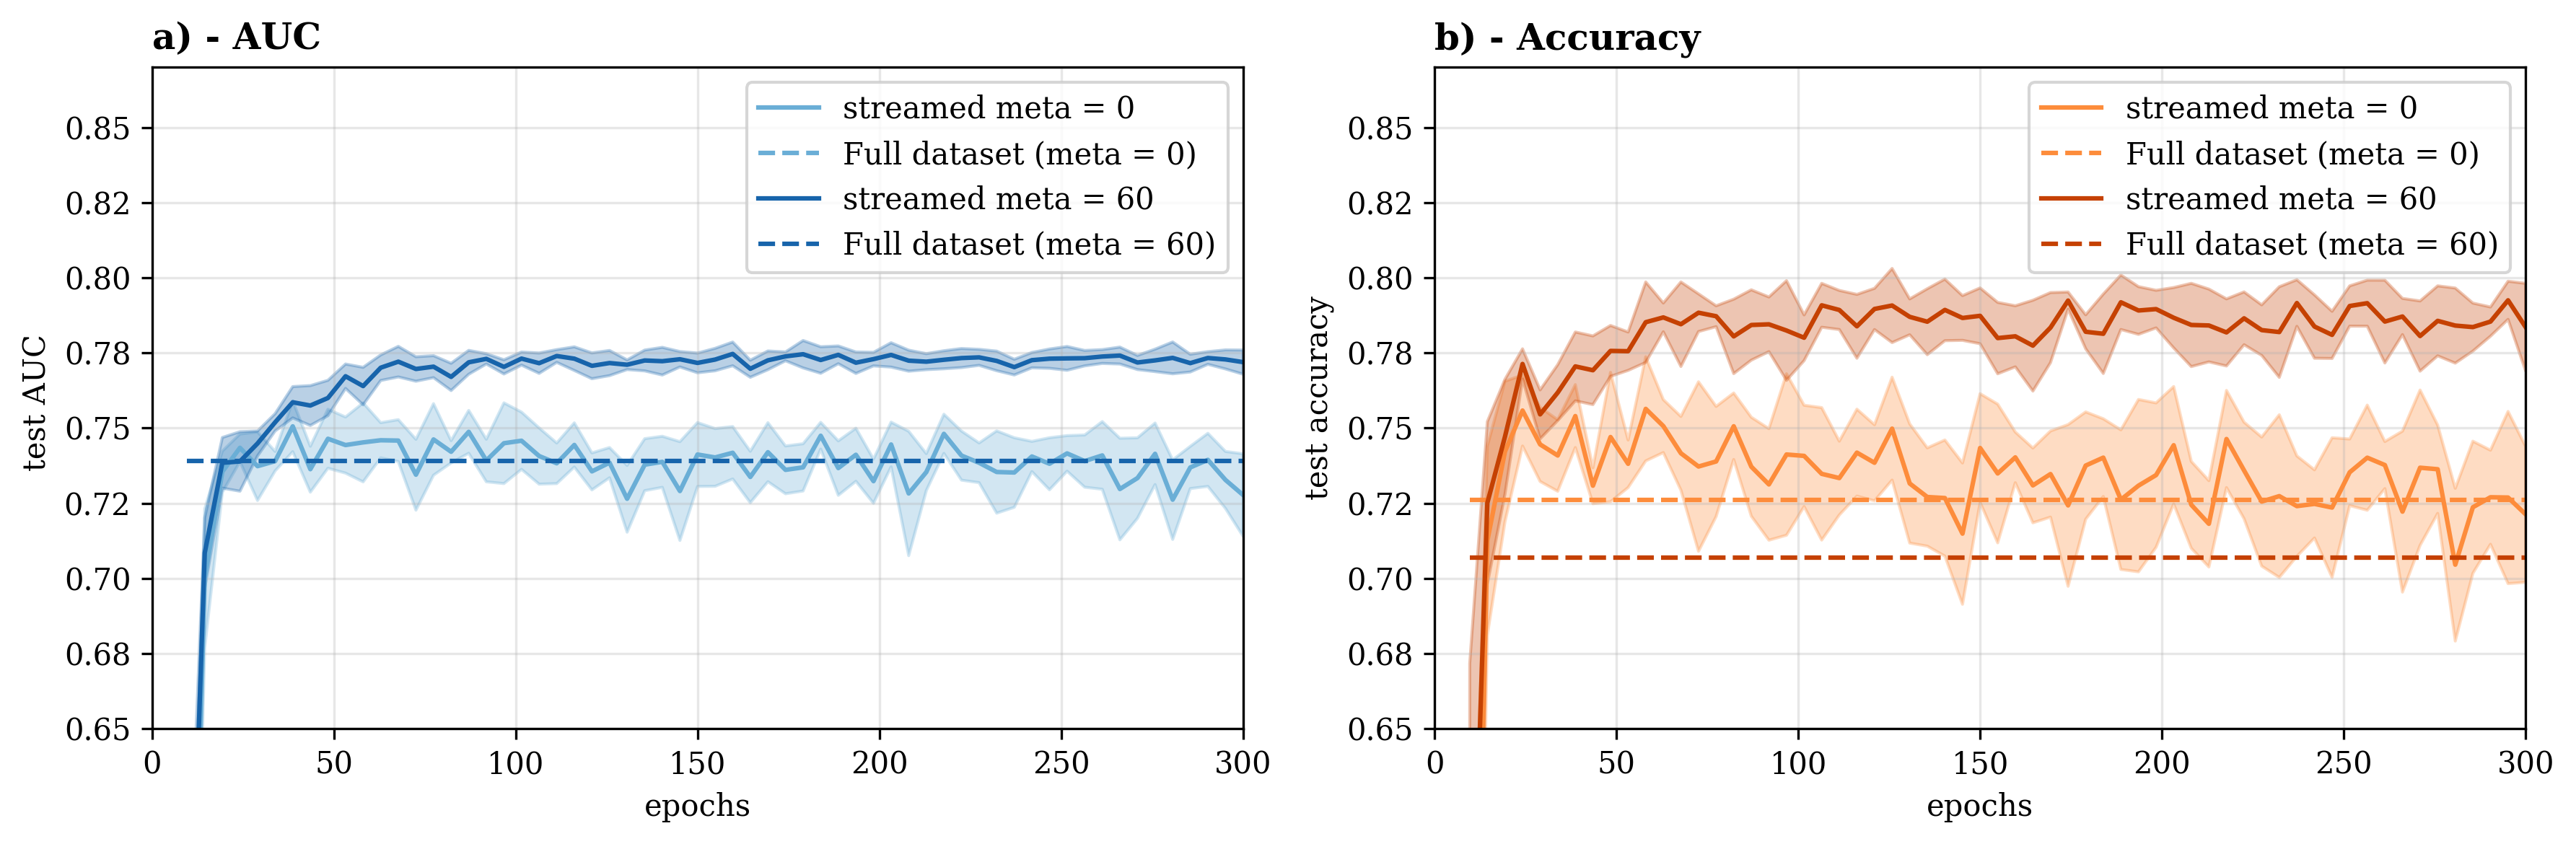

In [ ]:
plt.rcParams["font.family"] = "Arial"
number_meta = len(META_TO_PLOT)
number_subset = runs[meta_runs[0][0]].config["NUMBER_SUBSET"]

fig, ax = plt.subplots(2, 1, figsize=(8, 10), dpi=300)


# color selection =============================================================

# Generate a range of values between 0 and 1 for the colormaps
color_values = np.linspace(
    0.7, 1, number_meta
)  # Starts at 0.7 to avoid very light colors

# Get the colormap
cmap_auc = plt.cm.hsv
cmap_acc = plt.cm.hsv
cmap_fullpre = plt.cm.Greys

# Get the colors from the colormap
color_auc = [cmap_auc(value) for value in color_values]
color_acc = [cmap_acc(value) for value in color_values]
color_fullpre = cmap_fullpre(0.8)

# plot fullprecision network stream results =============================================================

 mean_auc_fullpre = meta_runs_auc_mean_fullpre[0]
 std_auc_fullpre = meta_runs_auc_std_fullpre[0]
 
 
 x_axis = ( 
     np.arange(+2, len(mean_auc_fullpre) + 2) / len(mean_auc_fullpre) * number_subset
 )


ax[0].plot(
    x_axis,
    mean_auc_fullpre,
    label=f"Streamed Full Precision Network",
    c=color_fullpre,
    linestyle="dotted",
)
ax[0].fill_between(
    x_axis,
    mean_auc_fullpre - std_auc_fullpre,
    mean_auc_fullpre + std_auc_fullpre,
    alpha=0.3,
    color=color_fullpre,
)

mean_acc_fullpre = meta_runs_acc_mean_fullpre[0]
std_acc_fullpre = meta_runs_acc_std_fullpre[0]

ax[1].plot(
    x_axis,
    mean_acc_fullpre,
    label=f"Streamed Full Precision Network",
    c=color_fullpre,
    linestyle="dotted",
)
ax[1].fill_between(
    x_axis,
    mean_acc_fullpre - std_acc_fullpre,
    mean_acc_fullpre + std_acc_fullpre,
    alpha=0.3,
    color=color_fullpre,
)


auc_ref = meta_runs_auc_mean_fullpre_ref[meta][-1]
acc_ref = meta_runs_acc_mean_fullpre_ref[meta][-1]

auc_ref = np.array([auc_ref] * 62)
acc_ref = np.array([acc_ref] * 62)

std_auc_ref = meta_runs_auc_std_fullpre_ref[meta][-1]
std_acc_ref = meta_runs_acc_std_fullpre_ref[meta][-1]

std_auc_ref = np.array([std_auc_ref] * 62)
std_acc_ref = np.array([std_acc_ref] * 62)


ax[0].plot(
    x_axis,
    auc_ref,
    label=f"Full Precision Dataset (meta = {meta})",
    linestyle="--",
    c=color_fullpre,
)

ax[0].fill_between(
    x_axis,
    auc_ref - std_auc_ref,
    auc_ref + std_auc_ref,
    alpha=0.3,
    color=color_fullpre,
)

ax[1].plot(
    x_axis,
    acc_ref,
    label=f"Full Precision Dataset (meta = {meta})",
    linestyle="--",
    c=color_fullpre,
)

ax[1].fill_between(
    x_axis,
    acc_ref - std_acc_ref,
    acc_ref + std_acc_ref,
    alpha=0.3,
    color=color_fullpre,
)


# plot BNN stream results =============================================================

for meta_index, meta in enumerate(META_TO_PLOT):
    # plot AUC

    mean = meta_runs_auc_mean[meta]
    std = meta_runs_auc_std[meta]

    x_axis = np.arange(+2, len(mean) + 2) / len(mean) * number_subset

    ax[0].plot(
        x_axis,
        mean,
        label=f"Streamed (meta = {meta})",
        c=color_auc[meta_index],
    )
    ax[0].fill_between(
        x_axis,
        mean - std,
        mean + std,
        alpha=0.3,
        color=color_auc[meta_index],
    )

    ax[0].set_ylabel("Test AUC", fontsize=22)
    ax[0].tick_params(axis='both', labelsize=18)

    # plot ACC

    mean = meta_runs_acc_mean[meta]
    std = meta_runs_acc_std[meta]

    ax[1].plot(
        x_axis,
        mean,
        label=f"Streamed (meta = {meta})",
        c=color_acc[meta_index],
    )
    ax[1].fill_between(
        x_axis,
        mean - std,
        mean + std,
        alpha=0.3,
        color=color_acc[meta_index],
    )

    ax[1].set_ylabel("Test Accuracy", fontsize=22)
    ax[1].tick_params(axis='both', labelsize=18)

    # plot the reference of full dataset training =============================================================

    auc_ref = meta_runs_auc_mean_ref[meta][-1]
    acc_ref = meta_runs_acc_mean_ref[meta][-1]

    auc_ref = np.array([auc_ref] * 62)
    acc_ref = np.array([acc_ref] * 62)

    std_auc_ref = meta_runs_auc_std_ref[meta][-1]
    std_acc_ref = meta_runs_acc_std_ref[meta][-1]

    std_auc_ref = np.array([std_auc_ref] * 62)
    std_acc_ref = np.array([std_acc_ref] * 62)

    ax[0].plot(
        x_axis,
        auc_ref,
        label=f"Full Dataset (meta = {meta})",
        linestyle="--",
        c=color_auc[meta_index],
    )

    ax[0].fill_between(
        x_axis,
        auc_ref - std_auc_ref,
        auc_ref + std_auc_ref,
        alpha=0.3,
        color=color_auc[meta_index],
    )

    ax[1].plot(
        x_axis,
        acc_ref,
        label=f"Full Dataset (meta = {meta})",
        linestyle="--",
        c=color_acc[meta_index],
    )

    ax[1].fill_between(
        x_axis,
        acc_ref - std_acc_ref,
        acc_ref + std_acc_ref,
        alpha=0.3,
        color=color_acc[meta_index],
    )

    # format the figure =============================================================

    metric = ["AUC", "Accuracy"]
    title = ["a)", "b)"]
    for colum_index in [0, 1]:
        ax[colum_index].set_yticklabels(
            ["{:.2f}".format(y) for y in ax[0].get_yticks()]
        )
        ax[colum_index].set_ylim([0.60, 0.82])
        ax[colum_index].set_xlim([0, 1])
        ax[colum_index].set_xticklabels(['0', '60', '120', '180', '240', '300'], fontsize=18)
        ax[colum_index].set_title(
            title[colum_index],
            loc="left",
            fontsize=22,
            x = 0.025,
            y = 0.9
        )
        ax[colum_index].grid(alpha=0.3)
        ax[1].set_xlabel("Subsets", fontsize=22)  # Set x-axis label only for the last row
        



        
# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Limit the legend to the first four items
limited_handles = handles[:4]
limited_labels = labels[:4]

# Create the legend with the limited handles and labels
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2,frameon=True, facecolor='white', fontsize='xx-large') # create legend for entire plot
legend.get_frame().set_edgecolor('white')

for handle in legend.legend_handles:
    handle.set_linewidth(2.5)

ax[0].set_xticklabels([]) # Remove x-axis from first subplot

plt.tight_layout()
plt.savefig(os.path.join(folder_to_save_figure, "stream_learning.pdf"), format="pdf")

4. Retrieving the last values of the test metrics


In [ ]:
for meta in sorted(meta_runs.keys()):
    print(
        f"Stream Meta: {meta} - AUC: {meta_runs_acc_mean[meta][-2]} - Accuracy: {meta_runs_acc_mean[meta][-2]}"
    )
    print(
        f"Full Meta: {meta} - AUC: {last_datapoint_auc[meta]} - Accuracy: {last_datapoint_acc[meta]}"
    )

Stream Meta: 0 - AUC: 0.721314995845121 - Accuracy: 0.721314995845121
Full Meta: 0 - AUC: 0.5834772588147936 - Accuracy: 0.7260805019467242
Stream Meta: 60 - AUC: 0.7835774908265875 - Accuracy: 0.7835774908265875
Full Meta: 60 - AUC: 0.7391931424068459 - Accuracy: 0.7069493851712837
